# Homework 4 - Linear SVM with Huberdize Hinge Loss
## BIOST 558 Spring 2020 
### Juan Solorio


#### Module and Data Preparation

In [2]:
# Needed Libraries

# vizualization
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

# data manipulation
import numpy as np 
import pandas as pd

# Machine Learning
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.svm import LinearSVC

In [3]:
# Loading data for train and test sets from source
vowels_train = pd.read_table("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.train",sep=",")
vowels_test = pd.read_table("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.test",sep=",")

# making a larger data set by combining train and test DFs to them split
vowels = pd.concat([vowels_train,vowels_test])

# selecting only those rows in column 'y' = [1,2,3] 
vowel_red = vowels.loc[vowels['y'].isin([1,2,3])]
vowel_red['y'] = vowel_red['y'].replace({2: -1, 3: -1})

# splitting into features [x's] and response [y's] 
x = pd.DataFrame(vowel_red.iloc[:,2:])
y = pd.DataFrame(vowel_red.iloc[:,1])

# setting values to then feed to train_test_split for train, test, validation sets
X = x.values
y = np.array(y).T[0]

# Splitting sets from X and y to their train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


# Standardize the data. 
scaler = sklearn.preprocessing.StandardScaler() 
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Keep track of the number of samples and dimension of each sample 
n_train = len(y_train) 
n_val = len(y_val)
n_test = len(y_test) 
d = np.size(x_train, 1)

/home/juansolo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Exercise 1 
#### Linear Support Vector Machine with Huberdize Hinge Loss Theory

For a Linear SVM with Huberdize Hinge Loss we have the objective equation to minimize:

\begin{equation}
\min_{\beta}F(\beta) = \lambda\|\beta\|^2_2 + \frac{\rho}{n}\sum_{i=1,y_i=+1}^n L_{hh}(y_i,x^T_i\beta) + \frac{1 - \rho}{n}\sum_{i=1,y_i=-1}^n L_{hh}(y_i,x^T_i\beta) 
\end{equation}

where $L_{hh}$ is defined as:


$$ L_{hh}(y,t)=   \left\{
\begin{array}{ll}
      0 &  if\ \ yt>1 + h \\
      \frac{(1+h-yt)^2}{4h} & if\ \ |1-yt| \leq h \\
      1-yt & if\ \ yt < 1-h \\
\end{array} 
\right.  $$

The equation can be thought of as:

\begin{equation}
\min_{\beta}F(\beta) = \lambda\sum_{j=1}^d\beta_j^2 + \frac{1}{n}(\ \rho \sum_{i=1,y_i=+1}^n L_{hh}(y_i,\sum_{j=1}^dx_j\beta_j) + \ (1-\rho)\sum_{i=1,y_i=-1}^n L_{hh}(y_i,\sum_{j=1}^dx_j\beta_j))
\end{equation}

Using the machine learning convention for the labels that is $y_i\ \in$ {−1, +1}

Assuming features ($d=1$) and samples ($n=1$), we can compute the $\nabla F$ as follows:


Using the machine learning convention for the labels that is $y_i\ \in$ {−1, +1}

Assuming $d=1$ and $n=1$, we can compute the $\nabla F$ as follows:

\begin{equation}
F(\beta) = \lambda\beta^2 + \frac{1}{n}L_{hh}(y,x\beta)(\rho + (1 - \rho)) \\
\end{equation}

where we would take the derivative of $L_{hh}$ with respect to $\beta$, giving us:

$$ \\ \frac{\partial}{\partial\beta}L_{hh}(y,x\beta)=   \left\{
\begin{array}{ll}
      0 &  if\ \ yt>1 + h \\
      \frac{-yx(1+h-yx\beta)}{2h} & if\ \ |1-yt| \leq h \\
      -yx & if\ \ yt < 1-h \\
\end{array} 
\right.  $$

where $t=x\beta$ 

so we can rewrite the equation for the gradient $\nabla F$ as:

\begin{equation}
\Rightarrow \frac{\partial F}{\partial \beta} =2\lambda\beta - xy \frac{1}{n}\ \frac{\partial}{\partial\beta}( L_{hh}(y,x\beta))(\rho + (1 - \rho))\\
\end{equation}

and we can write in terms of matrix vectorization as:

\begin{equation}
\\ \nabla F(\beta) = 2\lambda\beta - x^Ty \frac{1}{n}\ \frac{\partial}{\partial\beta}( L_{hh}(y,x^T\beta))(\rho + (1 - \rho))\\
\end{equation}

where we have $\rho$ for $y_i=+1$ and $1-\rho$ for $y_i=-1$.

##### Function Definitions

In [4]:
def Lhh(y,t,h_0 = 0.5):
    """
    Calculates the piecewise function for the Huberdize Hinge Loss
    
    parameters:
    ------------
    y: response variables in the form of numpy.array
    
    t: numpy.array of the dot product between preditor variables and weights
    
    h_0: (optional) Value for the piecewise selection, default to 0.5
    
    
    Returns:
    ------------
    an array of same size as y (the number of features n)
    """
    yt = y*t

    return np.piecewise(yt,
                        [yt - 1> h_0, np.abs(1 - yt) <= h_0, 1 - yt > h_0], 
                        [0,lambda x: ((1 + h_0 - x)**2)/(4*h_0), lambda x: 1 - x])

In [5]:
def dLhh_dt(y,X,b,h_0 = 0.5):
    """
    calculates the derivative of the piecewise funtion for the Huberdize Hinge Loss
    
    Parameters:
    -------------
    y: response variables in the form of numpy.array
    
    X: numpy.array of preditor variables 
    
    b: numpy.arry of the weights
    
    h_0: (optional) Value for the piecewise selection, default to 0.5
    
    
    Returns:
    ------------
    an array of same size as y (the number of features n)
    """
    yt = (X@b)*y
    
#     Follows the below logic for the piecewise function:
#     -----------------------------------------------------
#     if yt > 1 + h_0:
#         return 0
#     elif np.abs(1 - yt) <= h_0:
#         return (X.T @ -y*(1 + h_0 - yt))/(2*h_0)
#     else:
#         return -X.T*y

    return np.where(yt - 1> h_0, 0,
                    np.where(np.abs(1 - yt) <= h_0,-1 * (1 + h_0 -yt)/(2*h_0),
                             np.where(1 - yt > h_0,-1,float('inf'))))

In [6]:
def Fx_LinearSVMHH(b,p_rho,lamda,X,y):
    """
    Calculates the Objective function for the Linear SVM with Hubirdize Hinge Loss
    
    Parameters:
    -------------
    y: response variables in the form of numpy.array
    
    X: numpy.array of preditor variables 
    
    b: numpy.arry of the weights
    
    p_rho: value for the inbalance parameter
    
    lamda: value for the regularization parameter
    
    
    Returns:
    ------------
    a value for the objective function equal to the penalty + the sum of all Lhh piecewise functions for 
    each response variable
    """
    
    penalty = lamda * np.linalg.norm(b)**2
    
    lhh = np.piecewise(Lhh(y, X@b),[y == 1, y == -1],
                       [lambda x: p_rho/len(y) * x,lambda x:(1-p_rho)/len(y) * x])
    
    return penalty + sum(lhh)

In [7]:
def computegrad(b,p_rho,lamda,X,y):
    """
    Computes the gradient of the Fx_LinearSVMHH function by calculating dLhh_dt for the provided imputs
    
    Parameters:
    -------------
    y: response variables in the form of numpy.array
    
    X: numpy.array of preditor variables 
    
    b: numpy.arry of the weights
    
    p_rho: value for the inbalance parameter
    
    lamda: value for the regularization parameter
    
    
    Returns:
    ------------
    the gradient for the given y,X,b 
    """
    
    penalty = 2 * lamda * b 
    
    dlhh = np.piecewise(dLhh_dt(y=y,X=X,b=b),[y == 1, y == -1],
                       [lambda x: p_rho/len(y) * x,lambda x:(1-p_rho)/len(y) * x])
    
    return penalty + X.T@(y*dlhh)

In [8]:
def backtracking(beta, lamda, rho, X, y, eta=1, alpha=0.5, betaparam=0.8, maxiter=100): 
    """
    Function for the backtracking algorigthm to be used in the gradient (fast gradient) descent
    
    Parameters:
    -------------
    y: response variables in the form of numpy.array
    
    X: numpy.array of preditor variables 
    
    beta: numpy.arry of the weights
    
    rho: value for the inbalance parameter
    
    lamda: value for the regularization parameter
    
    eta: (optional)
    
    alpha: (optional)
    
    betaparam: (optional) 
    
    maxiter: (optional)
    
    
    Returns:
    ------------
    eta: updated value of eta 
    """
    grad_beta = computegrad(b=beta, p_rho=rho,lamda=lamda, X=X, y=y ) 
    norm_grad_beta = np.linalg.norm(grad_beta) 
    found_eta = 0 
    num_iters = 0 
    while found_eta == 0 and num_iters < maxiter: 
        if Fx_LinearSVMHH(beta - eta * grad_beta,p_rho=rho,lamda=lamda,X=X,y=y) <  Fx_LinearSVMHH(beta, p_rho=rho, lamda=lamda, X=X, y=y) - alpha * eta * norm_grad_beta ** 2: 
            found_eta = 1 
        elif num_iters == maxiter: 
            raise ('Max number of iterations of backtracking line search reached') 
        else: 
            eta *= betaparam 
            num_iters += 1 
        
    return eta

In [9]:
def mylinearsvm(X,y,rho,epsilon,lamda):
    """
    Function for the fast gradient descent for the SVM algorithm
    
    Parameters:
    -------------
    y: response variables in the form of numpy.array
    
    X: numpy.array of preditor variables 
    
    epsilon: optimization accuracy
    
    rho: value for the inbalance parameter
    
    lamda: value for the regularization parameter
    
    
    Returns:
    ------------
    arrays for the weights (beta_vals), gradient (grad_vals), and objective function values (fx_vals)
    """
    
    L = (np.max(np.linalg.eig(1/len(y)*X.T@X)[0])) + lamda
    eta_l = 1/L
    beta = np.zeros(X.shape[1])
    theta = np.zeros(X.shape[1])
    
    grad_theta = computegrad(theta,p_rho=rho,lamda=lamda,X=X,y=y) 
    grad_beta = computegrad(beta,p_rho=rho,lamda=lamda,X=X,y=y)
    fx = Fx_LinearSVMHH(b=beta,p_rho=rho,lamda=lamda,X=X,y=y)
    
    fx_vals = [fx]
    beta_vals = beta
    theta_vals = theta
    grad_vals = [grad_beta]
    fx_vals = [fx]
    num_iters = 0
    while np.linalg.norm(grad_beta) > epsilon:
        eta_l = backtracking(beta=beta, lamda = lamda, rho=rho, X=X, y=y, eta=eta_l, alpha=0.5, betaparam=0.8, maxiter=100)
        beta_new = theta - eta_l * grad_theta
        theta = beta_new + (num_iters/(num_iters+3)) * (beta_new - beta)
        
        beta_vals = np.vstack((beta_vals, beta))
        theta_vals = np.vstack((theta_vals, theta))
        
        grad_theta = computegrad(theta,p_rho=rho,lamda=lamda,X=X,y=y)
        grad_beta = computegrad(beta,p_rho=rho,lamda=lamda,X=X,y=y)
        
        beta = beta_new
        num_iters += 1
        
        grad_vals.append(grad_beta)
        fx = Fx_LinearSVMHH(b=beta,p_rho=rho,lamda=lamda,X=X,y=y)
        fx_vals.append(fx)
        
    return [beta_vals,grad_vals,fx_vals]


In [10]:
def compute_misclassification_error(b, X, y): 
    """
    Computes the missclassification error of the SVM for the calculated weights from the fast gradient descent
    
    Parameters:
    -------------
    y: response variables in the form of numpy.array
    
    X: numpy.array of preditor variables 
    
    b: numpy.arry of the weights
    
    
    Returns:
    -------------
    The missclassification value of y_pred != y_actual
    """
    y_hat =  X @ b
    y_pred = np.piecewise(y_hat,[y_hat >= 0, y_hat <0],[lambda x: 1, lambda x: -1])
    return np.mean(y_pred != y)

- Train your linear support vector machine with the huberized hinge loss on the the
Vowel dataset for $\lambda$ = 1 and $\rho$ = 1. Report the misclassification error for these hyperparameter values. Report the sensitivity and the specificity for these hyperparameter
values

In [12]:
betas_tr, grad_tr, fx_val_tr = mylinearsvm(X=x_train, y=y_train, rho=1, epsilon=5.1**-3, lamda=1)

print('My Betas:', betas_tr[-1])
print('My Fx vals:', fx_val_tr[-1])


clasification_err = compute_misclassification_error(b=betas_tr[-1],X=x_val,y=y_val)
print('\nMisclasification Error: ', clasification_err)

My Betas: [-0.0794309  -0.10958102  0.05048789  0.08989048  0.03426658  0.05809781
  0.00762705 -0.01965592 -0.02614803 -0.02866649]
My Fx vals: 0.2740737787435712

Misclasification Error:  0.3148148148148148


- Train your linear support vector machine with the huberized hinge loss on the the
Vowel dataset for $\lambda$ = 1 and $\rho$ = 0.1, 0.2, . . . , 0.9, 1.0. Plot the misclassification error
vs. the imbalance parameter $\rho$. Plot on the same figure yet with different colors the
sensitivity and the specificity vs. the imbalance parameter $\rho$

In [13]:
def y_pred(X,b, threshold=0):
    """
    Calculates Predicted y_hat values for the given X predictor variables and b weights
    """
    y_hat = (X @ b)
    y_pred = np.piecewise(y_hat,[y_hat >= threshold, y_hat <threshold],[lambda x: 1, lambda x: -1])
    
    return y_pred

An ROC curve plots the true positive rate vs. the false positive rate as the threshold is varied. Here we have
$$ \text{True positive rate} = \text{Recall} = \frac{\text{# True positives}}{\text{# True positives + # False negatives}} $$
and
$$ \text{False positive rate} = \frac{\text{# False positives}}{\text{# False positives + # True negatives}}. $$

$$ \text{Sensitivity} = \text{True positive rate} = \text{Recall} = \frac{\text{# True positives}}{\text{# True positives + # False negatives}} $$
and
$$ \text{Specificity} = \text{True negative rate} = \frac{\text{# True negatives}}{\text{# True negatives + # False positives}}. $$

In [14]:
def Calc_Sensitivity_Specificity(X, y_actual, b, threshold=0):
    """
    Calculates Sensitivity and Specificity for the predicted y_hat values from
    the provided X predictor variables and b weights compared to the y_actual
    """
    yhat = y_pred(X=X,b=b, threshold=threshold)
    
    TP = np.sum(yhat[yhat == 1] == y_actual[yhat==1])
    TN = np.sum(yhat[yhat == -1] == y_actual[yhat==-1])
    FP = np.sum(yhat[yhat == 1] != y_actual[yhat==1])
    FN = np.sum(yhat[yhat == -1] != y_actual[yhat==-1])

    sensitivity = TP/(TP+FN) 
    specificity = TN/(TN+FP)
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    
    return [sensitivity, specificity,TPR,FPR]

In [17]:
def plot_misclassification_error(X_train, y_train, X_test, y_test, lamda,rhos,save_file='',title=''):
    beta_vals=[]
    errors = []
    sens_val = []
    spes_val = []
    for rho in rhos:
        betas, grads, fx_val = mylinearsvm(X=X_train, y=y_train, rho=rho, epsilon=5.1**-3, lamda=lamda)
        beta_vals.append(betas[-1])
        error = compute_misclassification_error(b=betas[-1],X=X_test,y=y_test)
        errors.append(error)
        sensitivity, specificity , tpr, fpr= Calc_Sensitivity_Specificity(X=X_test, y_actual=y_test,b=betas[-1])
        sens_val.append(sensitivity)
        spes_val.append(specificity)
    fig, ax = plt.subplots()  
    ax.plot(rhos, errors, label='Error')
    ax.plot(rhos, spes_val, c='blue', label='Specificity')
    ax.plot(rhos, sens_val, c='green', label='Sensitivity')
    ax.legend(loc='upper right')
    plt.xlabel(r'$\rho$ values')
    plt.ylabel('Misclassification, Specificity, Sensitivity')
    plt.title(title)
    plt.show()

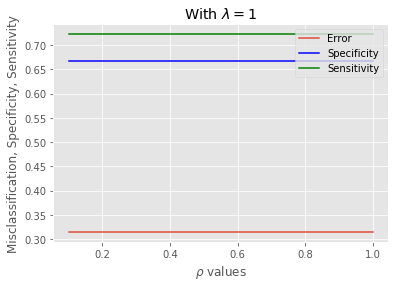

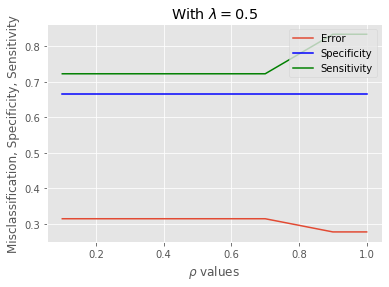

In [19]:
rhos=np.arange(1,11)/10
plot_misclassification_error(X_train=x_train, y_train=y_train,
                            X_test=x_val, y_test=y_val, lamda=1,rhos=rhos,title=r'With $\lambda=1$')
plot_misclassification_error(X_train=x_train, y_train=y_train,
                            X_test=x_val, y_test=y_val, lamda=.5,rhos=rhos,title=r'With $\lambda=0.5$')


In [21]:
def ROC_curve(X, y, b, threshold=np.arange(-1.0,1.1,.1)):
    tpr_v = []
    fpr_v = []
    for i in threshold:
        sensitivity, specificity, tpr, fpr = Calc_Sensitivity_Specificity(X=X, y_actual=y,b=b,threshold=i)
        tpr_v.append(tpr)
        fpr_v.append(fpr)
        
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.plot(fpr_v,tpr_v)

- Select the best value of the pair $\lambda$ and $\rho$ on a grid of values of your choice in terms
of area under the sensitivity/(1-specificity) curve obtained from the validation set.
Compute the sensitivity and the specificity on the testing set for the best values found
for the pair $\lambda$ and $\rho$

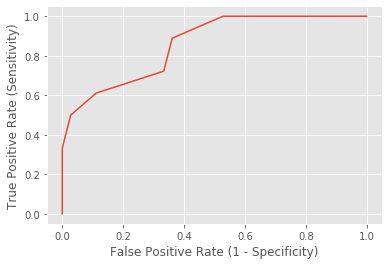

In [22]:
ROC_curve(X=x_val, y=y_val, b=betas_tr[-1])

In [25]:
betas_val, grad_val, fx_val_val = mylinearsvm(X=x_train, y=y_train, rho=.8, epsilon=5.1**-3, lamda=.5)

sensitivity, specificity,TPR,FPR = Calc_Sensitivity_Specificity(X=x_test, y_actual=y_test, b=betas_val[-1])

print("Sensitivity: ", sensitivity ,"\nSpecificity: ",specificity)


clasification_err_test = compute_misclassification_error(b=betas_tr[-1],X=x_test,y=y_test)
print('\nMisclasification Error: ', clasification_err_test)

Sensitivity:  0.9090909090909091 
Specificity:  0.71875

Misclasification Error:  0.24074074074074073


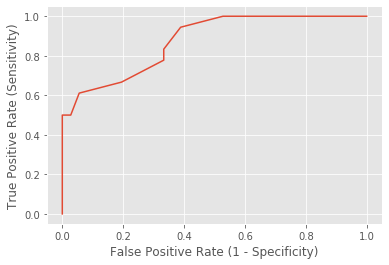

In [26]:
ROC_curve(X=x_val, y=y_val, b=betas_val[-1])

### Exercise 2

*In this exercise, you are facing several challenging situations and you are asked to suggest
effective strategies to tackle them, based on your knowledge in statistical machine learning
and data science in general. Please answer the questions for each situation in a few lines.
Please feel free to write equations or draw figures if it helps.*

##### *Linear regression insomnia.* Alex is Bobbie’s manager. Alex is a workaholic and Bobbie suffers from insomnia. Bobbie wants to design a deep network to predict the covid-19 pandemic evolution. At 3am, Bobbie receives a text from Alex asking her to log in her computer for a zoom meeting. Alex wants Bobbie to design, implement, run, and validate a linear regression model on a dataset. Bobbie has 2hrs to deliver the model and the predictions to Alex. Tyler adamantly forbids Frankie to use any off-the-shelf package because of IP concerns. Bobbie calls you through zoom and asks for your advice regarding the best optimization algorithm to use in this case, since you took DATA 558 at UW. Which optimization algorithm do you advise your friend Bobbie to use? Explain why

Due to the fact that we Bobbie is trying to predict the covid-19 pandemic evolution in 2 hours, I would suggest an algorithm with the use of fast gradient descent and a loglikelihood loss function given the fact that covid-19 is a virus and grows at an exponential rate.


##### *The next big thing.* Joey is a colleague of yours. Joey has been working with Tyler on a binary classification task for a particular real-world problem. Joey and Tyler have collected a dataset to work on this classification task. Joey sends you a zoom meeting request. While his kid is jumping on his lap, he claims he has just revolutionized machine learning. You ask him to tell you more. Joey says his method manages to predict perfectly on the test set. A striking feature of Joey’s revolutionary approach is to use the test set (examples and labels) at training time. Joey says he did some research and apparently no one has ever applied this strategy in research papers or books. What do you think about Joey’s revolutionary approach? How much would you invest in Joey’s new company?

From the description of Joey's approach, it sounds like his model is experiencing *data leakage*. This means that there information other than the training set, in this case the test set, contaminating the data pool as it will cause the model overfit and not be generalize enough to handle new data once it comes in. Joey can not compare how well his model does vs the test set as he no longer as an unbiased test set that the model has not seen, hense I would invest in Joey's company but likely sell the stocks quickly once I make a quick profit as it is likely to fail.